##Setting

In [ ]:
##connect to Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##install library for wordcloud
!pip install wordcloud
!pip install tenserflowhub
!pip install keras tf-models-official pydot graphviz

ERROR: Could not find a version that satisfies the requirement tenserflowhub (from versions: none)
ERROR: No matching distribution found for tenserflowhub
     |████████████████████████████████| 1.1MB 12.7MB/s 
     |████████████████████████████████| 1.2MB 35.6MB/s 
     |████████████████████████████████| 174kB 53.3MB/s 
     |████████████████████████████████| 358kB 39.2MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=8738af0083da9cff9e30d2e0ed2843615e6a8b366bb1578209b3334868e273ff
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=0e7bb819e845d26c72d0ae4360ec3b740203cf35d65142437652d0ed56610332
  Stored in directory: /root/.cache/p

In [ ]:
##import Libraries

import pandas as pd
from os import path
import numpy as np
import re

from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

##Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Text Analytics/twitter_sentiment-main/twitter_sentiment-main/training.1600000.processed.noemoticon.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'id',
                        'date',
                        'flag',
                        'user',
                        'text'
                        ])

In [ ]:
##check content
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
##check target (y)
df.target.unique()

array([0, 4])

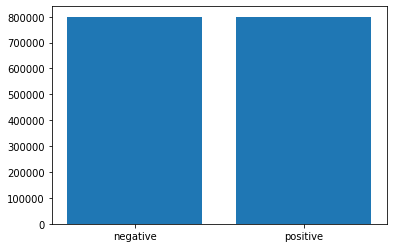

In [ ]:
##check imbalance class
classes=df.target.unique()

counts=[]
for i in classes:
  count=len(df[df.target==i])
  counts.append(count)

plt.bar(['negative','positive'],counts)
plt.show()

In [ ]:
#check for duplicate
df['dup']=df.duplicated(subset=None, keep='first')

In [ ]:
df.head()

,target,id,date,flag,user,text,dup
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",False
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,False
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,False
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,False
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",False


In [ ]:
#if dup=True, meaning taht the duplicated value exist & need to be removed
df.dup.unique()

array([False])

(-0.5, 399.5, 199.5, -0.5)

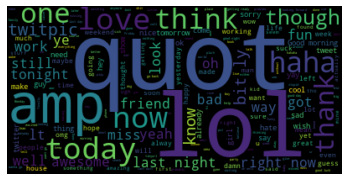

In [ ]:
##wordcloud to visualize initial dataset
wordcloud=WordCloud().generate(' '.join(df['text']))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In [ ]:
##check top 10 word frequency
Counter(' '.join(df['text']).split()).most_common(10)

[('to', 552962),
 ('I', 496619),
 ('the', 487501),
 ('a', 366212),
 ('my', 280025),
 ('and', 275263),
 ('i', 250016),
 ('is', 217693),
 ('you', 213871),
 ('for', 209801)]

In [ ]:
#remove unwnated column
cols = [1,3,4]
df.drop(df.columns[cols],axis=1,inplace=True)

In [ ]:
df.head()

,target,date,text,dup
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",False
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,False
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,False
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,False
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",False


In [ ]:
##remove URL
def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

In [ ]:
df['prep']=df['text'].apply(remove_URL)
df.head()

,target,date,text,dup,prep
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",False,"@switchfoot - Awww, that's a bummer. You sho..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,False,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,False,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,False,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",False,"@nationwideclass no, it's not behaving at all...."


In [ ]:
stop_words_file = '/content/drive/MyDrive/Text Analytics/text_analysis_python_101-master/text_analysis_python_101-master/SmartStoplist.txt'

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [ ]:
nltk.download('wordnet')

df['prep1']=df['prep'].apply(preprocess)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,target,date,text,dup,prep,prep1
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",False,"@switchfoot - Awww, that's a bummer. You sho...",switchfoot awww bummer shoulda david carr day
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,False,is upset that he can't update his Facebook by ...,upset update facebook texting cry result schoo...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,False,@Kenichan I dived many times for the ball. Man...,kenichan dived time ball managed save rest bound
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,False,my whole body feels itchy and like its on fire,body feel itchy like fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",False,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad


In [ ]:
##remove unwanted column
cols = [2,3,4]
df.drop(df.columns[cols],axis=1,inplace=True)

In [ ]:
df.head()

,target,date,prep1
0,0,Mon Apr 06 22:19:45 PDT 2009,switchfoot awww bummer shoulda david carr day
1,0,Mon Apr 06 22:19:49 PDT 2009,upset update facebook texting cry result schoo...
2,0,Mon Apr 06 22:19:53 PDT 2009,kenichan dived time ball managed save rest bound
3,0,Mon Apr 06 22:19:57 PDT 2009,body feel itchy like fire
4,0,Mon Apr 06 22:19:57 PDT 2009,nationwideclass behaving mad


##wordcloud after preprocessing

(-0.5, 399.5, 199.5, -0.5)

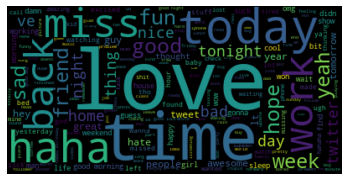

In [ ]:
wordcloud=WordCloud().generate(' '.join(df['prep1']))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In [ ]:
Counter(" ".join(df["prep1"]).split()).most_common(20)

[('day', 109395),
 ('good', 91496),
 ('like', 79924),
 ('work', 68748),
 ('today', 68713),
 ('love', 68634),
 ('time', 65827),
 ('back', 57118),
 ('night', 45826),
 ('home', 40680),
 ('miss', 38747),
 ('morning', 35212),
 ('hope', 34765),
 ('tomorrow', 34339),
 ('twitter', 34176),
 ('great', 33558),
 ('haha', 31518),
 ('sad', 29430),
 ('fun', 28729),
 ('sleep', 28352)]

##save to H5

In [ ]:
df.to_csv('/content/drive/MyDrive/Text Analytics/twitter_sentiment-main/twitter_sentiment-main/tweetdt_cleaned.csv')